In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path  
from scipy.stats import skew, kurtosis
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATA_DIR = Path("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train")

print("Available training folders:", [p.name for p in DATA_DIR.iterdir()])

Available training folders: ['defog', 'tdcsfog', 'notype']


In [3]:
tdcsfog_file = list((DATA_DIR / "tdcsfog").glob("*.csv"))[0]
defog_file   = list((DATA_DIR / "defog").glob("*.csv"))[0]
notype_file  = list((DATA_DIR / "notype").glob("*.csv"))[0]

print("Sample files chosen:")
print("tdcsfog:", tdcsfog_file.name)
print("defog:", defog_file.name)
print("notype:", notype_file.name)

Sample files chosen:
tdcsfog: a171e61840.csv
defog: be9d33541d.csv
notype: 1e8d55d48d.csv


In [4]:
tdcsfog_df = pd.read_csv(tdcsfog_file)
defog_df   = pd.read_csv(defog_file)
notype_df  = pd.read_csv(notype_file)

In [5]:
for name, df in [("tdcsfog", tdcsfog_df), ("defog", defog_df), ("notype", notype_df)]:
    print(f"\n=== {name.upper()} ===")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print(df.head(3))   
    print(df.info())    


=== TDCSFOG ===
Shape: (7400, 7)
Columns: ['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking']
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.665890  0.042550  0.184744                0     0        0
1     1 -9.672969  0.049217  0.184644                0     0        0
2     2 -9.670260  0.033620  0.193790                0     0        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             7400 non-null   int64  
 1   AccV             7400 non-null   float64
 2   AccML            7400 non-null   float64
 3   AccAP            7400 non-null   float64
 4   StartHesitation  7400 non-null   int64  
 5   Turn             7400 non-null   int64  
 6   Walking          7400 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 404.8 KB
None

=== DEFOG ===
Shape: (1188

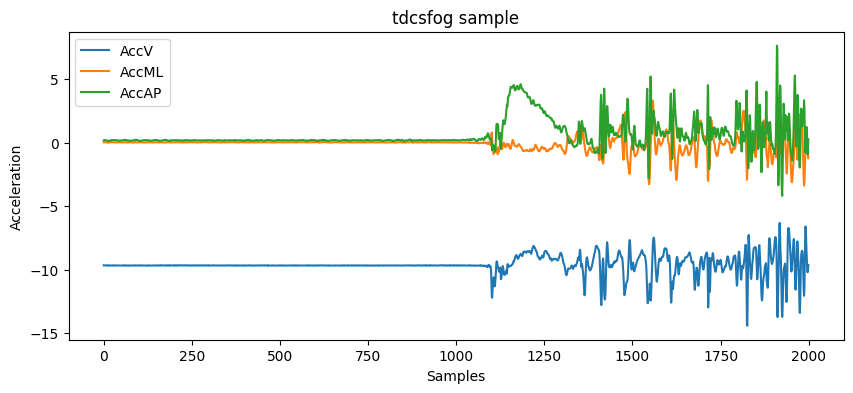

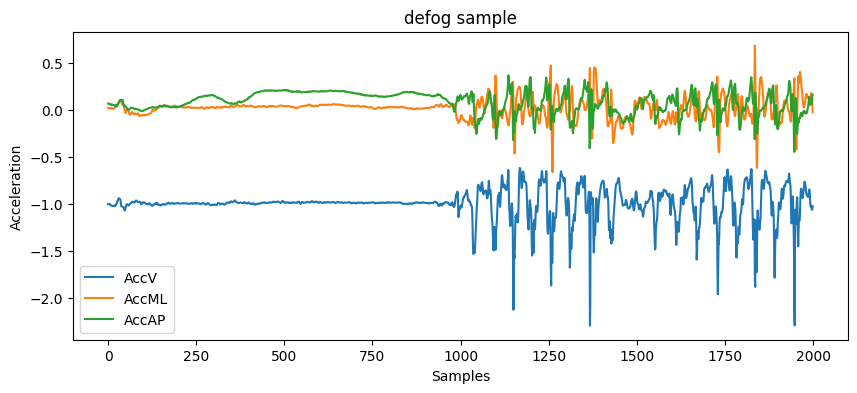

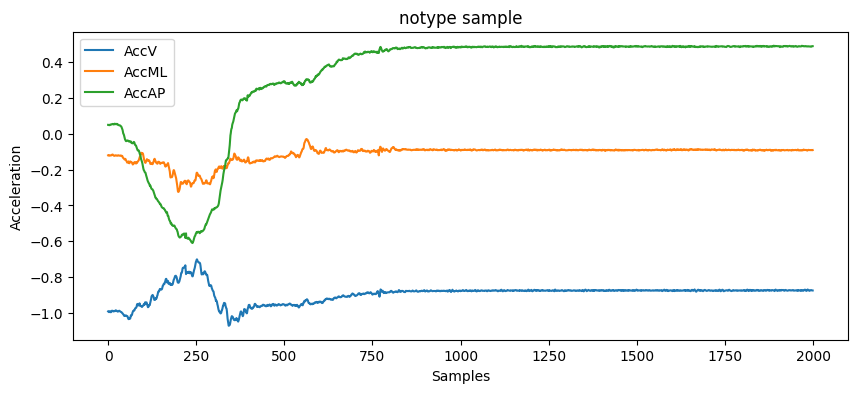

In [6]:
def plot_signals(df, title, n=2000):
    df[["AccV", "AccML", "AccAP"]].head(n).plot(figsize=(10,4), title=title)
    plt.xlabel("Samples")
    plt.ylabel("Acceleration")
    plt.show()

plot_signals(tdcsfog_df, "tdcsfog sample")
plot_signals(defog_df, "defog sample")
plot_signals(notype_df, "notype sample")

In [7]:
import re

def tdcsfog_time_features(df, fs=128.0, win_s=2.0, hop_s=0.5):
    """
    Extract time-domain features from accelerometer data in tdcsfog_df.
    Works purely in pandas.
    """

    # --- auto-detect accelerometer columns ---
    cols = list(df.columns)
    lower = {c.lower(): c for c in cols}
    candidates = [
        ['AccX','AccY','AccZ'],
        ['AccelX','AccelY','AccelZ'],
        ['acc_x','acc_y','acc_z'],
        ['AccV','AccML','AccAP'],
        ['accv','accml','accap'],
    ]
    acc_cols = None
    for trio in candidates:
        found = [lower.get(c.lower()) for c in trio]
        if all(found):
            acc_cols = found
            break
    if acc_cols is None:
        acc_cols = [c for c in cols if re.search('acc', c, re.I)][:3]
    if len(acc_cols) < 3:
        raise KeyError(f"Could not find 3 accelerometer columns. Found: {acc_cols}")

    # --- label columns ---
    label_cols = [c for c in ['StartHesitation','Turn','Walking'] if c in df.columns]

    # --- window setup ---
    win = int(round(fs * win_s))
    hop = int(round(fs * hop_s))
    n = len(df)

    X = df[acc_cols].to_numpy(dtype=float)
    rows = []
    start = 0
    win_id = 0

    while start + win <= n:
        end = start + win
        W = X[start:end, :]
        f = {}

        # per-axis features
        for i, c in enumerate(acc_cols):
            w = W[:, i]
            f[f'{c}_mean']   = np.nanmean(w)
            f[f'{c}_std']    = np.nanstd(w)
            f[f'{c}_var']    = np.nanvar(w)
            f[f'{c}_min']    = np.nanmin(w)
            f[f'{c}_max']    = np.nanmax(w)
            f[f'{c}_median'] = np.nanmedian(w)
            q75, q25 = np.nanpercentile(w, [75, 25])
            f[f'{c}_iqr']    = q75 - q25
            f[f'{c}_energy'] = np.nansum(w**2) / len(w)
            f[f'{c}_rms']    = np.sqrt(np.nanmean(w**2))
            f[f'{c}_skew']   = skew(w, nan_policy='omit', bias=False)
            f[f'{c}_kurt']   = kurtosis(w, nan_policy='omit', fisher=True, bias=False)

        # vector magnitude features
        mag = np.sqrt(np.sum(W**2, axis=1))
        f['Acc_mag_mean'] = np.nanmean(mag)
        f['Acc_mag_std']  = np.nanstd(mag)
        f['Acc_sma']      = np.nansum(np.abs(W)) / len(W)

        # correlations
        def corr_safe(a,b):
            if len(a) > 1 and np.isfinite(a).all() and np.isfinite(b).all():
                return np.corrcoef(a,b)[0,1]
            return np.nan
        f[f'corr_{acc_cols[0]}_{acc_cols[1]}'] = corr_safe(W[:,0], W[:,1])
        f[f'corr_{acc_cols[0]}_{acc_cols[2]}'] = corr_safe(W[:,0], W[:,2])
        f[f'corr_{acc_cols[1]}_{acc_cols[2]}'] = corr_safe(W[:,1], W[:,2])

        # labels (if exist)
        if label_cols:
            sub = df.iloc[start:end][label_cols].fillna(0).to_numpy()
            f['label_any'] = bool((sub > 0).any())
            for j, c in enumerate(label_cols):
                f[f'label_{c}'] = bool((sub[:, j] > 0).any())

        # window metadata
        f['win_id'] = win_id
        f['t_start_s'] = start / fs
        f['t_end_s']   = (end - 1) / fs

        rows.append(f)
        win_id += 1
        start += hop

    return pd.DataFrame(rows)

In [8]:
# parameters
FS = 128.0
WIN = 2.0   # 2 seconds per window
HOP = 0.5   # 0.5-second step

tdcsfog_feats = tdcsfog_time_features(tdcsfog_df, fs=FS, win_s=WIN, hop_s=HOP)

print("Detected accelerometer columns:", [c for c in tdcsfog_feats.columns if 'mean' in c][:3])
print("Shape:", tdcsfog_feats.shape)
tdcsfog_feats.head()

Detected accelerometer columns: ['AccV_mean', 'AccML_mean', 'AccAP_mean']
Shape: (112, 46)


,AccV_mean,AccV_std,AccV_var,AccV_min,AccV_max,AccV_median,AccV_iqr,AccV_energy,AccV_rms,AccV_skew,...,corr_AccV_AccML,corr_AccV_AccAP,corr_AccML_AccAP,label_any,label_StartHesitation,label_Turn,label_Walking,win_id,t_start_s,t_end_s
0,-9.676408,0.006617,0.000044,-9.694637,-9.659135,-9.676250,0.009232,93.632915,9.676410,0.050714,...,-0.017974,0.029742,0.048487,False,False,False,False,0,0.0,1.992188
1,-9.676400,0.006681,0.000045,-9.694637,-9.659135,-9.676654,0.009463,93.632758,9.676402,0.044396,...,0.005490,-0.003859,-0.119356,False,False,False,False,1,0.5,2.492188
2,-9.675996,0.006480,0.000042,-9.693737,-9.659135,-9.675782,0.008877,93.624931,9.675998,0.030831,...,-0.022001,0.057198,-0.154278,False,False,False,False,2,1.0,2.992188
3,-9.677018,0.006550,0.000043,-9.693737,-9.659135,-9.677447,0.008826,93.644711,9.677020,0.154207,...,-0.070649,0.158226,-0.169971,False,False,False,False,3,1.5,3.492188
4,-9.678382,0.006107,0.000037,-9.693737,-9.660702,-9.679372,0.006954,93.671120,9.678384,0.272114,...,-0.019138,0.080240,-0.089752,False,False,False,False,4,2.0,3.992188
